# Sugestão de cidade do Estado do Rio Grande do Sul pelo Índice de Criminalidade
### Para o trabalho final da disciplina de Sistemas Operacionais foi escolhido os bancos de dados Índice de Criminalidade (RS, 2023) e Estimativas Populacionais (RS, 2022). Os dados são reais e estão disponíveis no portal Dados Abertos RS do Estado do Rio Grande do Sul.
###  O objetivo principal é analisar como o algoritmo k-means irá agrupar as cidades. Com este resultado, será possível responder: "Quais as cidades o algoritmo sugere?". De acordo com a resposta, futuramente seria possível o desenvolvimento de uma aplicação real de sugestão de cidade.

Indíce de Criminalidade no RS: [https://dados.rs.gov.br/dataset/indicadores-criminais-de-2023](https://dados.rs.gov.br/dataset/indicadores-criminais-de-2023)

Estimativas Populacionais no RS: [https://dados.rs.gov.br/dataset/dee-4259/resource/ce259dd9-c479-4a18-90b3-40098e6deb26](https://dados.rs.gov.br/dataset/dee-4259/resource/ce259dd9-c479-4a18-90b3-40098e6deb26)

## Pré-processamento
### Houve a necessidade de realizar o pré-processamento dos dados, pois foram disponibilizados em planilhas Excel com formatações diversas.

In [1325]:
import pandas as pd

#### Abertura dos arquivos de criminalidade por cidade em cada mês.

In [1326]:
# Lendo os arquivos csv e concatenando em um único dataframe
meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

dfs = []

for mes in meses:
        arquivo = pd.read_csv(f'data\\tocsv\\{mes}.csv', delimiter=';')
        dfs.append(arquivo)

df = pd.concat(dfs, ignore_index=True)

df_criminal = df.groupby(['municipios', 'ibge']).sum().reset_index()


df.to_csv('data\\tocsv\\total.csv', sep=';', index=False)

df_criminal.head()


,municipios,ibge,homicidio_doloso,total_vitimas_homicidio_doloso,latrocinio,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,total_vitimas_crimes_violentos
0,acegua,4300034,0,0,0,20,8,0,3,0,27,4,3,0,0,0,0
1,agua santa,4300059,1,1,0,20,3,4,1,0,13,2,0,0,0,0,2
2,agudo,4300109,1,1,0,102,2,2,3,1,51,3,7,10,0,0,1
3,ajuricaba,4300208,0,0,0,26,1,0,1,0,28,2,3,0,0,0,0
4,alecrim,4300307,1,1,0,36,10,0,2,0,17,10,0,4,0,0,1


#### Abertura do arquivo de quantidade de população por cidade em cada ano.

In [1327]:
# Lendo o arquivo de população
df_pop = pd.read_csv('data\\tocsv\\populacao.csv', delimiter=';')

# Substituindo os valores de '.' e '-' por 0 e convertendo para inteiro
for coluna in df_pop.columns[4:]:
    df_pop[coluna] = df_pop[coluna].str.replace('.', '').str.replace('-', '0').astype(int)

df_pop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   municipios  497 non-null    object 
 1   ibge        497 non-null    int64  
 2   latitude    497 non-null    float64
 3   longitude   497 non-null    float64
 4   2010        497 non-null    int32  
 5   2011        497 non-null    int32  
 6   2012        497 non-null    int32  
 7   2013        497 non-null    int32  
 8   2014        497 non-null    int32  
 9   2015        497 non-null    int32  
 10  2016        497 non-null    int32  
 11  2017        497 non-null    int32  
 12  2018        497 non-null    int32  
 13  2019        497 non-null    int32  
 14  2020        497 non-null    int32  
 15  2021        497 non-null    int32  
dtypes: float64(2), int32(12), int64(1), object(1)
memory usage: 39.0+ KB


### União dos dois banco de dados

In [1328]:
# O merge é feito com base na coluna ibge como forma de chave estrangeira com o método inner
df_merged = pd.merge(df_criminal, df_pop, how = 'inner', on = 'ibge').drop(columns=['municipios_y'])
df_merged.rename(columns={'municipios_x': 'municipios'}, inplace=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   municipios                      497 non-null    object 
 1   ibge                            497 non-null    int64  
 2   homicidio_doloso                497 non-null    int64  
 3   total_vitimas_homicidio_doloso  497 non-null    int64  
 4   latrocinio                      497 non-null    int64  
 5   furtos                          497 non-null    int64  
 6   abigeato                        497 non-null    int64  
 7   furto_veiculo                   497 non-null    int64  
 8   roubos                          497 non-null    int64  
 9   roubo_veiculo                   497 non-null    int64  
 10  estelionato                     497 non-null    int64  
 11  delitos_armas_municoes          497 non-null    int64  
 12  entorpecente_posse              497 

### Normalização dos dados

In [1329]:
from sklearn.preprocessing import StandardScaler

In [1330]:
# Lista das colunas extras que não são necessárias
colunas_extras = df_merged.columns[16:30]

# Removendo as colunas extras
df = df_merged.drop(colunas_extras, axis=1)

df.set_index('municipios', inplace=True)

# Salvando o dataframe em um arquivo csv
df.to_csv('data\\tocsv\\dados_pop_criminalidade.csv', sep=';', index=False)

df.head()



,ibge,homicidio_doloso,total_vitimas_homicidio_doloso,latrocinio,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,2021
municipios,,,,,,,,,,,,,,,,
acegua,4300034,0,0,0,20,8,0,3,0,27,4,3,0,0,0,4505
agua santa,4300059,1,1,0,20,3,4,1,0,13,2,0,0,0,0,4256
agudo,4300109,1,1,0,102,2,2,3,1,51,3,7,10,0,0,16612
ajuricaba,4300208,0,0,0,26,1,0,1,0,28,2,3,0,0,0,7447
alecrim,4300307,1,1,0,36,10,0,2,0,17,10,0,4,0,0,6403


In [1331]:
# Removendo as colunas de taxa total pois são redundantes
df.drop(['total_vitimas_homicidio_doloso'], axis='columns', inplace=True)
df.drop(['latrocinio'], axis='columns', inplace=True)

# Selecionando somente as colunas do tipo float
df.drop(['ibge'], axis='columns', inplace=True)

df.rename(columns={'2021': 'populacao'}, inplace=True)

In [1332]:
# Normalizando os dados média 0 e desvio padrão 1
scaler = StandardScaler(with_std=True, with_mean=True)
data_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

data_scaled.head()

,homicidio_doloso,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,populacao
municipios,,,,,,,,,,,,,
acegua,-0.240983,-0.165023,-0.016371,-0.189482,-0.091215,-0.108250,-0.174139,-0.221637,-0.264673,-0.205293,-0.202622,-0.193052,-0.234986
agua santa,-0.163812,-0.165023,-0.347109,-0.145451,-0.094148,-0.108250,-0.190466,-0.270616,-0.287715,-0.205293,-0.202622,-0.193052,-0.238138
agudo,-0.163812,-0.106419,-0.413257,-0.167466,-0.091215,-0.093268,-0.146148,-0.246127,-0.233949,-0.141324,-0.202622,-0.193052,-0.081756
ajuricaba,-0.240983,-0.160734,-0.479404,-0.189482,-0.094148,-0.108250,-0.172972,-0.270616,-0.264673,-0.205293,-0.202622,-0.193052,-0.197751
alecrim,-0.163812,-0.153588,0.115925,-0.189482,-0.092681,-0.108250,-0.185801,-0.074700,-0.287715,-0.179705,-0.202622,-0.193052,-0.210964


## Redução de Dimensionalidade
### O dataset agora tem dados suficientes para ranquear as cidades em mais seguras e não seguras com dados proporcionais a população. Entretanto, existem muitas colunas. A alta dimensionalidade deixará o processo de aprendizado confuso criando um sobreajuste nos dados. Então é aplicado o PCA, uma técnida de redução de dimensionalidade.
### Para fins de demonstração, será usado somente uma amostra de 20 cidades.



In [1333]:
# Selecionando 20 linhas aleatórias
df_sample= data_scaled.sample(n=25, axis=0, random_state=999)

df_sample.index



Index(['hulha negra', 'sao valentim do sul', 'xangri-la', 'nova padua',
       'catuipe', 'esmeralda', 'lajeado do bugre', 'cruz alta', 'nova ramada',
       'jaguarao', 'nova petropolis', 'charqueadas', 'torres', 'sarandi',
       'fortaleza dos valos', 'almirante tamandare do sul', 'esteio',
       'frederico westphalen', 'canela', 'piratini', 'vale verde',
       'restinga seca', 'santo antonio da patrulha', 'passo do sobrado',
       'sao sepe'],
      dtype='object', name='municipios')

In [1334]:
import numpy as np

from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA


In [1335]:
# Aplicando a PCA
pca = PCA()
components = pca.fit_transform(df_sample)

components.shape[1]

13

In [1336]:
# Analise de como os componentes estão explicando os dados com a variância explicada
pca.explained_variance_ratio_

array([3.81403134e-01, 3.35609185e-01, 1.40727454e-01, 7.49776034e-02,
       4.64638856e-02, 1.41957814e-02, 2.98215223e-03, 2.68379209e-03,
       5.28358386e-04, 3.23701599e-04, 6.66889179e-05, 3.82634109e-05,
       0.00000000e+00])

In [1337]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

In [1338]:
# Plotando o gráfico da variância explicada acumulada
px.area(
    x=range(1, pca.explained_variance_ratio_.cumsum().shape[0] + 1),
    y=pca.explained_variance_ratio_.cumsum(),
    labels={"x": "Componentes Principais", "y": "Variância Explicada Acumulada"}
)


In [1339]:
n = 4

# Aplicando a PCA com n componentes
pca = PCA(n_components=n)
components = pca.fit_transform(df_sample)

components.shape[1]

4

### Dataframe agora utilizando os componentes principais para explicar os dados de criminalidade nas cidades

In [1340]:
df_pca = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['municipios'] = df_sample.index
df_pca.set_index('municipios', inplace=True)
df_pca.head()

,PC1,PC2,PC3,PC4
municipios,,,,
hulha negra,-0.601557,0.075443,-0.145768,0.006247
sao valentim do sul,-0.682314,-0.512254,-0.072228,0.019699
xangri-la,0.044404,-0.434083,-0.035557,-0.017995
nova padua,-0.710398,-0.512442,-0.073661,0.017818
catuipe,-0.479446,-0.042584,-0.122929,0.173788


In [1341]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    df_pca,
    title=f'Taxa Total de Variancia Explicada por 4 PC: {total_var:.2f}%',
    dimensions=df_pca.columns,
    color=df_pca.index,
)
fig.update_traces(diagonal_visible=False)
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/'

In [1342]:
total_var_2 = pca.explained_variance_ratio_[:2].sum() * 100
total_var_2

# Calculando as cargas dos componentes
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Plotando o gráfico de dispersão com os componentes principais
fig = px.scatter(
    components, x=0, y=1, color=df_pca.index,
    labels={'0': 'PC1', '1': 'PC2', 'color': 'Município'},
    title=f'Taxa Total de Variancia Explicada por 2 PC: {total_var_2:.2f}%')

features = df_sample.columns

# Adicionando os vetores de carga ao gráfico
for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
# Invertendo o eixo y para que o gráfico fique na posição correta    
fig.update_yaxes(autorange="reversed")
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/'

In [1343]:
""" i, j = 0, 1 # which components
scale_arrow = s_ = 2
components[:,1] *= -1
pca.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(components[:,0], components[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])
    ax.text(s_*pca.components_[i,k],
            s_*pca.components_[j,k],
            df_sample.columns[k]) """

" i, j = 0, 1 # which components\nscale_arrow = s_ = 2\ncomponents[:,1] *= -1\npca.components_[1] *= -1 # flip the y-axis\nfig, ax = plt.subplots(1, 1, figsize=(8, 8))\nax.scatter(components[:,0], components[:,1])\nax.set_xlabel('PC%d' % (i+1))\nax.set_ylabel('PC%d' % (j+1))\nfor k in range(pca.components_.shape[1]):\n    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])\n    ax.text(s_*pca.components_[i,k],\n            s_*pca.components_[j,k],\n            df_sample.columns[k]) "

## K-means com dados brutos

In [1344]:
from sklearn import cluster

In [1345]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1346]:
# Aplicando o método de Elbow para encontrar o número de clusters
clusters = np.arange(1,10,1)

SSE = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300 , random_state=42)
    k_means.fit(df_sample)
    SSE.append(k_means.inertia_)

SSE

[38.14183883121085,
 26.069772323691808,
 16.694677593074317,
 10.885360205955351,
 8.104545675465403,
 6.290607791919857,
 4.410371841472981,
 3.27058503971652,
 2.2736160198614197]

Text(0, 0.5, 'SSE')

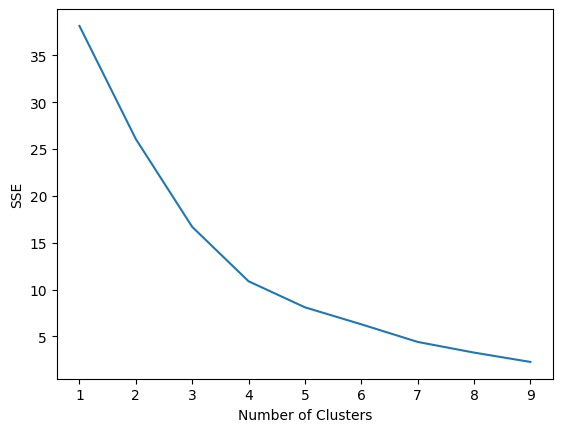

In [1347]:
# Plotando o gráfico do método de Elbow
plt.plot(clusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [1348]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [1349]:
# Aplicando o método de Silhouette para encontrar o número de clusters
clusters = np.arange(2,17,1)
SC = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
    k_means.fit(df_sample)
    SC.append(silhouette_score(df_sample, k_means.labels_))
SC

[0.40000081472309934,
 0.4827670545915395,
 0.5096353688098765,
 0.4853424281394582,
 0.36542727219721416,
 0.3611475116924892,
 0.38598224136772374,
 0.41262452976110464,
 0.39907975794477096,
 0.37672621257216166,
 0.3698651631267717,
 0.3262541733363864,
 0.3447067974785222,
 0.3095396823064154,
 0.30100602350120403]

Text(0, 0.5, 'SC')

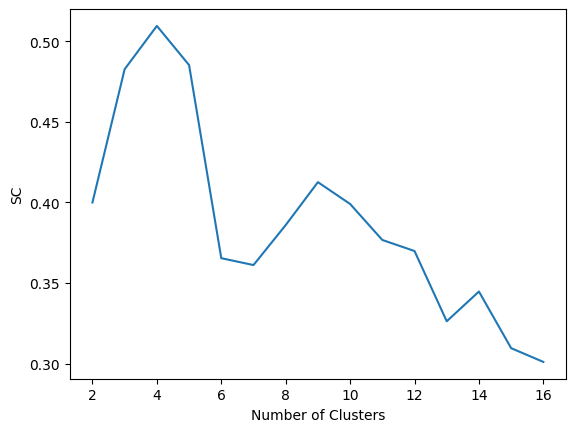

In [1350]:
# Plotando o gráfico do método de Silhouette
plt.plot(clusters, SC)
plt.xlabel('Number of Clusters')
plt.ylabel('SC')

In [1351]:
k = 4

# Aplicando o KMeans com k clusters
k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
k_means.fit(df_sample)

KMeans(n_clusters=4, n_init=25, random_state=42)

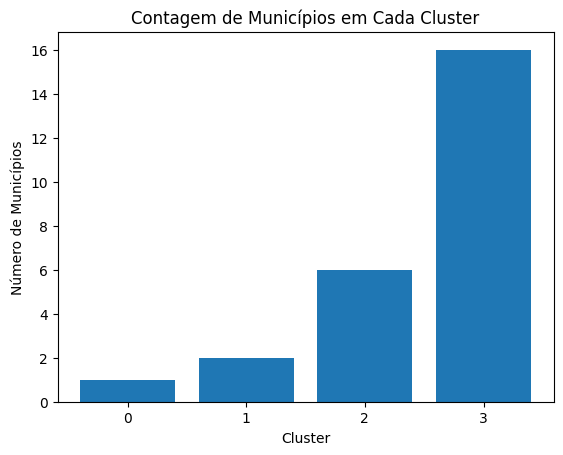

In [1352]:
# Contar a ocorrência de cada cluster
contagem = np.bincount(k_means.labels_)

# Plotar o gráfico de barras
plt.bar(range(len(contagem)), np.sort(contagem), tick_label=range(len(contagem)))
plt.xlabel('Cluster')
plt.ylabel('Número de Municípios')
plt.title('Contagem de Municípios em Cada Cluster')
plt.show()

## K-means com PCA

In [1353]:
# Aplicando o método de Elbow para encontrar o número de clusters
clusters = np.arange(1,15,1)

SSE = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
    k_means.fit(df_pca)
    SSE.append(k_means.inertia_)

SSE

[35.57555584160119,
 23.511056045494414,
 14.152426946112366,
 8.343191490953028,
 5.6407379691614725,
 3.849979998640109,
 2.7616102469556054,
 1.9540911439036686,
 1.4305824793838517,
 1.0340917012531279,
 0.7606782546186457,
 0.50293673001897,
 0.3183540740056437,
 0.17278580118086942]

Text(0, 0.5, 'SSE')

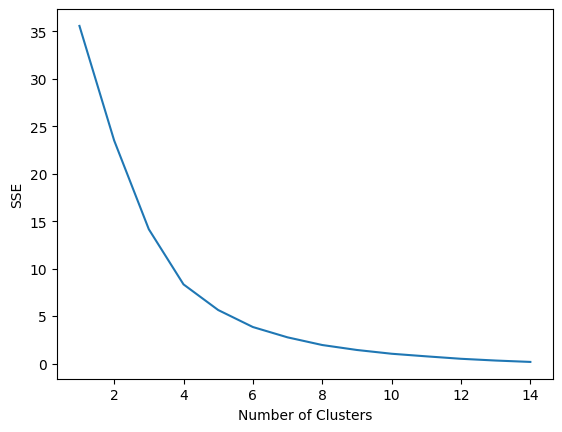

In [1354]:
# Plotando o gráfico do método de Elbow
plt.plot(clusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [1355]:
# Aplicando o método de Silhouette para encontrar o número de clusters
clusters = np.arange(2,14,1)
SC = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, random_state=123)
    k_means.fit(df_pca)
    SC.append(silhouette_score(df_pca, k_means.labels_))
SC

[0.4180611088534175,
 0.5108177574527998,
 0.5405847880932367,
 0.5327565574711679,
 0.4202498114866626,
 0.47463859180278917,
 0.4963846736337932,
 0.4664110830731373,
 0.45437289909514916,
 0.49003045331898787,
 0.4455214953469583,
 0.4191976443035264]

Text(0, 0.5, 'SC')

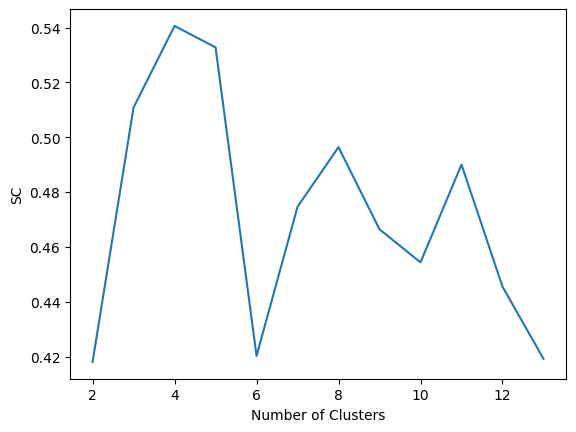

In [1356]:
# Plotando o gráfico do método de Silhouette
plt.plot(clusters, SC)
plt.xlabel('Number of Clusters')
plt.ylabel('SC')

In [1357]:
k = 4

# Aplicando o KMeans com n clusters
k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, random_state=123)
k_means.fit(df_pca)

KMeans(n_clusters=4, n_init=25, random_state=123)

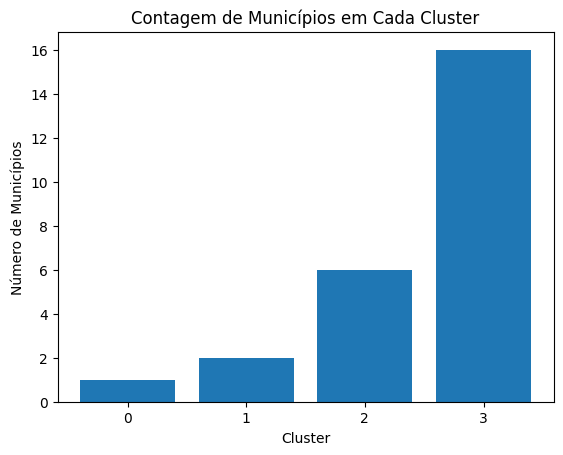

In [1358]:
# Plotar o gráfico de barras para contagem de municípios em cada cluster

# Contar a ocorrência de cada cluster
contagem = np.bincount(k_means.labels_)

plt.bar(range(len(contagem)), np.sort(contagem), tick_label=range(len(contagem)))
plt.xlabel('Cluster')
plt.ylabel('Número de Municípios')
plt.title('Contagem de Municípios em Cada Cluster')
plt.show()

In [1359]:
# Salvando os clusters no dataframe
labels = k_means.labels_
df_pca['cluster'] = labels

# Salvando o dataframe em um arquivo csv
df_pca.to_csv('data\\tocsv\\clusterizado.csv', sep=',', index=False)

df_pca.head()

,PC1,PC2,PC3,PC4,cluster
municipios,,,,,
hulha negra,-0.601557,0.075443,-0.145768,0.006247,0
sao valentim do sul,-0.682314,-0.512254,-0.072228,0.019699,0
xangri-la,0.044404,-0.434083,-0.035557,-0.017995,0
nova padua,-0.710398,-0.512442,-0.073661,0.017818,0
catuipe,-0.479446,-0.042584,-0.122929,0.173788,0


In [1360]:
# Criar o gráfico 3D
fig = go.Figure()

# Adicionar os pontos
fig.add_trace(
    go.Scatter3d(
        # Adicionar as dimensões PCA
        x=df_pca['PC1'],
        y=df_pca['PC2'],
        z=df_pca['PC3'],
        mode='markers',
        # Adicionar a cor de acordo com o cluster
        marker=dict(size=5, color=df_pca['cluster'], colorscale='viridis', opacity=0.8),
        # Adicionar o nome dos município ao passar o mouse
        text=df.index
))

# Adicionar o layout
fig.update_layout(
    title=f'Gráfico 3D dos {k} Clusters',
    # Adicionar o nome dos eixos
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Mostrar o gráfico
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico 3D: https://plotly.com/python/v3/3d-point-clustering/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico 3D: https://plotly.com/python/v3/3d-point-clustering/'

## Sistema de Recomendação

In [1361]:
df_ratings = pd.read_csv('data\\tocsv\\ratings.csv', delimiter=',')

df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          100 non-null    int64  
 1   first_name  100 non-null    object 
 2   gender      100 non-null    object 
 3   rating_1    0 non-null      float64
 4   rating_2    59 non-null     object 
 5   rating_3    99 non-null     object 
 6   rating_4    99 non-null     object 
 7   rating_5    97 non-null     object 
 8   rating_6    99 non-null     object 
 9   rating_7    99 non-null     object 
 10  rating_8    99 non-null     object 
 11  rating_9    42 non-null     object 
 12  rating_10   98 non-null     object 
 13  rating_11   99 non-null     object 
 14  rating_12   98 non-null     object 
 15  rating_13   98 non-null     object 
 16  rating_14   94 non-null     object 
 17  rating_15   77 non-null     object 
 18  rating_16   99 non-null     object 
 19  rating_17   93 non-null     ob

In [1362]:
df_ratings.drop(['id'], axis='columns', inplace=True)
df_ratings.drop(['gender'], axis='columns', inplace=True)
df_ratings.set_index('first_name', inplace=True)

df_ratings.rename(columns= {
    'rating_1': df_sample.index[0], 'rating_2': df_sample.index[1], 'rating_3': df_sample.index[2], 'rating_4': df_sample.index[3], 'rating_5': df_sample.index[4], 
    'rating_6': df_sample.index[5], 'rating_7': df_sample.index[6], 'rating_8': df_sample.index[7], 'rating_9': df_sample.index[8], 'rating_10': df_sample.index[9], 
    'rating_11': df_sample.index[10], 'rating_12': df_sample.index[11], 'rating_13': df_sample.index[12], 'rating_14': df_sample.index[13], 'rating_15': df_sample.index[14], 
    'rating_16': df_sample.index[15], 'rating_17': df_sample.index[16], 'rating_18': df_sample.index[17], 'rating_19': df_sample.index[18], 'rating_20': df_sample.index[19],
    'rating_21': df_sample.index[20], 'rating_22': df_sample.index[21], 'rating_23': df_sample.index[22], 'rating_24': df_sample.index[23], 'rating_25': df_sample.index[24]
    }, inplace=True)


A cidade nova, sem ratings é a primeira coluna do dataset ratings e por padrão iniciará com -1.

In [1363]:
df_ratings.iloc[:, 0] = -1
df_ratings = df_ratings.astype(float)


df_ratings.head()

,hulha negra,sao valentim do sul,xangri-la,nova padua,catuipe,esmeralda,lajeado do bugre,cruz alta,nova ramada,jaguarao,...,almirante tamandare do sul,esteio,frederico westphalen,canela,piratini,vale verde,restinga seca,santo antonio da patrulha,passo do sobrado,sao sepe
first_name,,,,,,,,,,,,,,,,,,,,,
Nadya,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
Thea,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
Elie,-1.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,NaN,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
Karlyn,-1.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
Eustacia,-1.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [1364]:
df_ratings = df_ratings.T.reset_index().rename(columns={'index': 'municipios'}).set_index('municipios')

df_ratings_pca = pd.merge(df_pca.iloc[:,:-1], df_ratings, how='inner', on='municipios')

df_ratings_pca.head()

,PC1,PC2,PC3,PC4,Nadya,Thea,Elie,Karlyn,Eustacia,Jodi,...,Peta,Addy,Clary,Edmund,Clemens,Barron,Joete,Melisenda,Eziechiele,Rachelle
municipios,,,,,,,,,,,,,,,,,,,,,
hulha negra,-0.601557,0.075443,-0.145768,0.006247,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
sao valentim do sul,-0.682314,-0.512254,-0.072228,0.019699,1.0,1.0,NaN,NaN,NaN,0.0,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN
xangri-la,0.044404,-0.434083,-0.035557,-0.017995,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
nova padua,-0.710398,-0.512442,-0.073661,0.017818,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
catuipe,-0.479446,-0.042584,-0.122929,0.173788,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [1365]:
df_ratings_pca.loc[df_ratings_pca['PC1'] < 0, 'PC1'] = 0
df_ratings_pca.loc[df_ratings_pca['PC1'] > 0, 'PC1'] = 1
df_ratings_pca.loc[df_ratings_pca['PC2'] < 0, 'PC2'] = 0
df_ratings_pca.loc[df_ratings_pca['PC2'] > 0, 'PC2'] = 1
df_ratings_pca.loc[df_ratings_pca['PC3'] < 0, 'PC3'] = 0
df_ratings_pca.loc[df_ratings_pca['PC3'] > 0, 'PC3'] = 1
df_ratings_pca.loc[df_ratings_pca['PC4'] < 0, 'PC4'] = 0
df_ratings_pca.loc[df_ratings_pca['PC4'] > 0, 'PC4'] = 1
df_ratings_pca.head()

,PC1,PC2,PC3,PC4,Nadya,Thea,Elie,Karlyn,Eustacia,Jodi,...,Peta,Addy,Clary,Edmund,Clemens,Barron,Joete,Melisenda,Eziechiele,Rachelle
municipios,,,,,,,,,,,,,,,,,,,,,
hulha negra,0.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
sao valentim do sul,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN
xangri-la,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
nova padua,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
catuipe,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [1366]:
df_ratings_pca = df_ratings_pca.fillna(df_ratings_pca.mean())
df_ratings_pca.head()


,PC1,PC2,PC3,PC4,Nadya,Thea,Elie,Karlyn,Eustacia,Jodi,...,Peta,Addy,Clary,Edmund,Clemens,Barron,Joete,Melisenda,Eziechiele,Rachelle
municipios,,,,,,,,,,,,,,,,,,,,,
hulha negra,0.0,1.0,0.0,1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.000000
sao valentim do sul,0.0,0.0,0.0,1.0,1.0,1.0,0.391304,0.391304,0.478261,0.0,...,1.0,0.304348,0.608696,0.52381,1.0,1.0,1.0,1.0,0.25,0.416667
xangri-la,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.0,...,1.0,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.00,0.000000
nova padua,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.000000,1.000000,1.0,...,1.0,1.000000,1.000000,1.00000,0.0,0.0,1.0,1.0,1.00,1.000000
catuipe,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.000000,1.000000,1.0,...,1.0,0.000000,1.000000,0.00000,0.0,0.0,0.0,1.0,1.00,1.000000


In [1367]:
df_ratings_pca.filter(['PC1', 'PC2', 'PC3', 'PC4','Barron'])

,PC1,PC2,PC3,PC4,Barron
municipios,,,,,
hulha negra,0.0,1.0,0.0,1.0,-1.000000
sao valentim do sul,0.0,0.0,0.0,1.0,1.000000
xangri-la,1.0,0.0,0.0,0.0,0.000000
nova padua,0.0,0.0,0.0,1.0,0.000000
catuipe,0.0,0.0,0.0,1.0,0.000000
esmeralda,0.0,0.0,0.0,1.0,0.000000
lajeado do bugre,0.0,0.0,0.0,1.0,1.000000
cruz alta,1.0,1.0,0.0,1.0,1.000000
nova ramada,0.0,0.0,0.0,1.0,0.208333


In [1368]:
# Substituindo NaNs por False e convertendo booleanos para 0 e 1
df_ratings_pca = df_ratings_pca.fillna(df_ratings_pca.mean())
df_ratings_pca.head()

,PC1,PC2,PC3,PC4,Nadya,Thea,Elie,Karlyn,Eustacia,Jodi,...,Peta,Addy,Clary,Edmund,Clemens,Barron,Joete,Melisenda,Eziechiele,Rachelle
municipios,,,,,,,,,,,,,,,,,,,,,
hulha negra,0.0,1.0,0.0,1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.000000,-1.000000,-1.00000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.000000
sao valentim do sul,0.0,0.0,0.0,1.0,1.0,1.0,0.391304,0.391304,0.478261,0.0,...,1.0,0.304348,0.608696,0.52381,1.0,1.0,1.0,1.0,0.25,0.416667
xangri-la,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.0,...,1.0,0.000000,0.000000,1.00000,0.0,0.0,0.0,0.0,0.00,0.000000
nova padua,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.000000,1.000000,1.0,...,1.0,1.000000,1.000000,1.00000,0.0,0.0,1.0,1.0,1.00,1.000000
catuipe,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0.000000,1.000000,1.0,...,1.0,0.000000,1.000000,0.00000,0.0,0.0,0.0,1.0,1.00,1.000000


In [1369]:

# Separando features e rótulos
X = df.drop(columns=["municipios"])
y = df["municipios"]

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o modelo Naive Bayes de Bernoulli
model = BernoulliNB()

# Treinando o modelo
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

# Previsões detalhadas
for municipio, pred in zip(y_test, y_pred):
    print(f"Verdadeiro: {municipio}, Previsto: {pred}")

KeyError: "['municipios'] not found in axis"